In [1]:
import pandas as pd 
import numpy as np 

data = pd.read_excel("数据整合.xlsx",sheet_name="指标数据").loc[0:9]
gdp = pd.read_excel("数据整合.xlsx",sheet_name="GDP")[["GDP（亿元）"]]

x_1 = data[["专利申请数"]]
x_2 = data[["劳动力"]].astype(int)    #数据格式转换
x_3 = data[["固定资本存量合计"]]
gdp = gdp.astype(int)                #数据格式转换


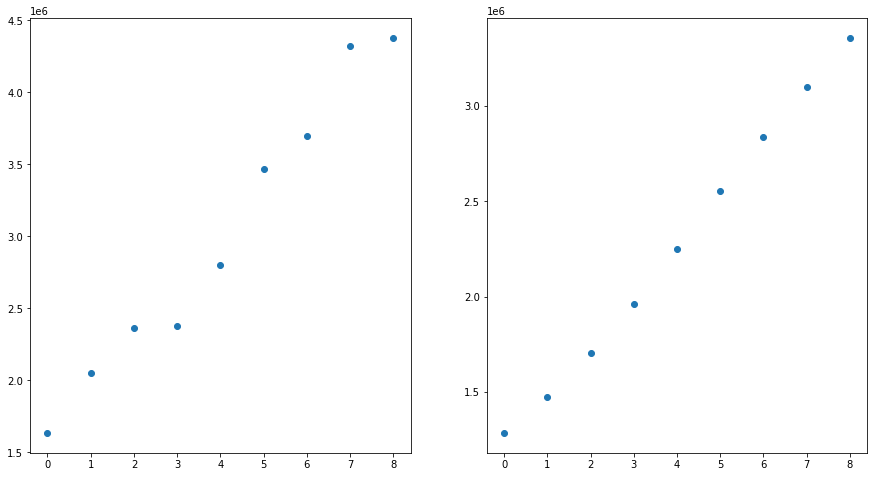

In [2]:
#观察带有缺失值指标的趋势，为选用插值函数做铺垫
import matplotlib.pyplot as plt    

fig, ax = plt.subplots(1,2,figsize=(15,8))

t = np.array([i for i in range(len(x_1))])
ax[0].scatter(t,x_1)
ax[1].scatter(t,x_3)

In [3]:
def type_change(x):                  #数据格式转换
    d = []
    for k in np.array(x.dropna()).reshape(len(x.dropna()),):
        d.append(k)
    return np.array(d)

In [4]:
def l(i,x):                          #插值函数定义
    y = type_change(x)
    from sklearn import linear_model
    model = linear_model.LinearRegression()
    t = np.array(x.dropna().index,dtype="int32")
    t = t.reshape(-1,1)
    y = y.reshape(-1,1)
    model.fit(t,y)
    k = model.predict(np.array([[i]]))
    return k[0][0]

In [5]:
x_1 = x_1.replace(np.nan,l(9,x_1))
x_3 = x_3.replace(np.nan,l(9,x_3))        #替换nan

In [6]:
#对数归一化
l_y = np.log(gdp)
l_h = np.log(x_1)
l_l = np.log(x_2)
l_k = np.log(x_3)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
l_y=scaler.fit_transform(l_y)
l_k=scaler.fit_transform(l_k)
l_l=scaler.fit_transform(l_l)
l_h=scaler.fit_transform(l_h)

In [8]:
def g(x,y,z):   #传入要合并的数据
    d = [[] for i in range(len(x))]   #初始化表格
    for i in range(len(d)):
        d[i].append(x[i][0])
        d[i].append(y[i][0])
        d[i].append(z[i][0])
        d[i] = np.array(d[i])
    return np.array(d)

In [9]:
x = g(l_k,l_l,l_h)        #将劳动、资本、技术三特征的值合并至一个矩阵

In [10]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(x,l_y)
print(model.coef_)
print(model.intercept_)

[[0.75536823 0.0209     0.24490323]]
[-0.02637251]


In [14]:
y_pre = model.predict(x)
sse = np.dot((y_pre[0]-l_y[0]),(y_pre[0]-l_y[0]))
mse = np.sqrt(sse/(len(y_pre)-1))

In [15]:
mse

0.008790837313741789

In [21]:
R_square

array([0.99936295])

In [27]:
def t_test(model,x):    #传入的参数有整个模型，样本解释变量(最后给出每个系数的p值)
    from scipy.stats import t 
    β = model.coef_[0]
    n = len(x)
    t_dist = t(n-1)
    sigma_hat_square = sse/(n-1)
    cov_β = np.linalg.inv((x.T@x))*sigma_hat_square
    p_value = []
    for i in range(3):                                          #计算p值
        t_value = (β[i]-0)/cov_β[i][i]
        if t_value < 0:
            p_value.append(2*t_dist.cdf(t_value))
        else:
            p_value.append(2*(1-t_dist.cdf(t_value)))
    return p_value

def R_square_and_adjusted_R_square(model,l_y):
    sst = 0
    y_bar = np.mean(l_y)
    for i in range(len(l_y)):
        sst += (l_y[i]-y_bar)**2
    R_square = (sst-sse)/sst
    adjust_R_square = 1 - (sse/sst)*n/(n-1)
    return R_square,adjust_R_square


In [28]:
t_test(model,x)

[0.0, 4.440892098500626e-15, 2.859934511434403e-13]

In [29]:
R_square_and_adjusted_R_square(model,l_y)

(array([0.99936295]), array([0.99929216]))